In [4339]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
raw_df=pd.read_csv('hacktrain.csv')
test_df=pd.read_csv('hacktest.csv')

In [4341]:
nvdi_columns=raw_df.columns.tolist()[29:3:-1]
raw_df=raw_df[['ID','class']+nvdi_columns]
test_df=test_df[nvdi_columns]
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(raw_df, test_size=0.2,stratify=raw_df['class'],random_state=42)

In [4343]:
train_df['class']

1157    forest
5776    forest
4327    forest
4053    forest
189     forest
         ...  
2688    forest
1113    forest
7489      farm
374     forest
1903    forest
Name: class, Length: 6400, dtype: object

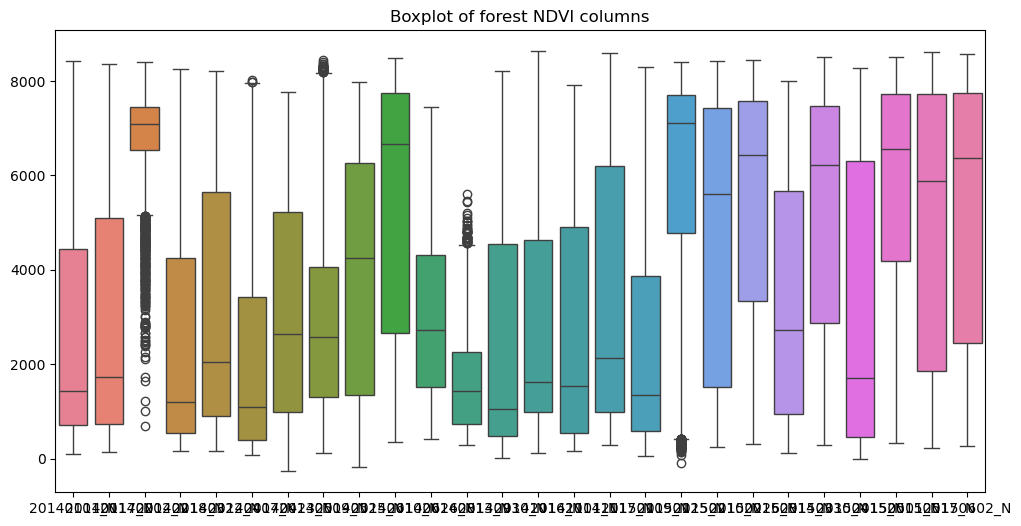

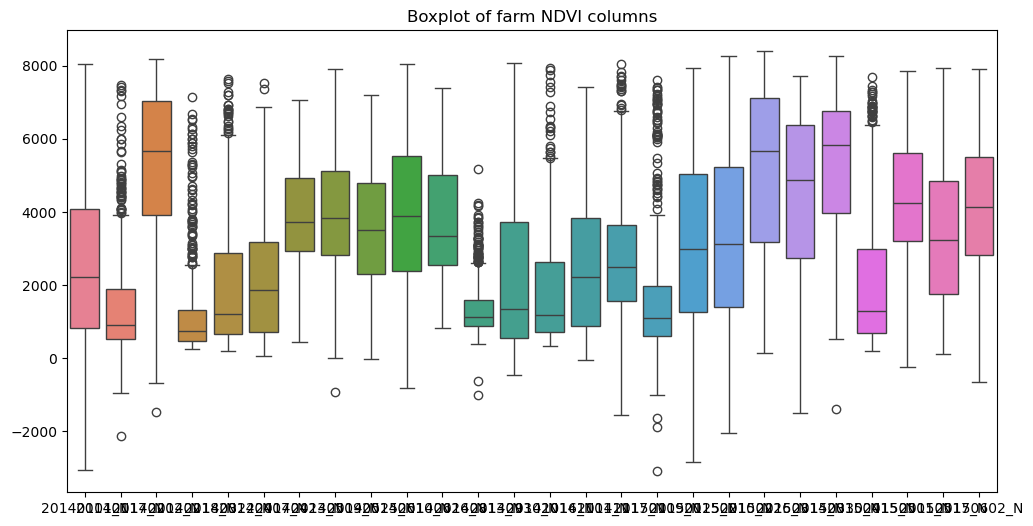

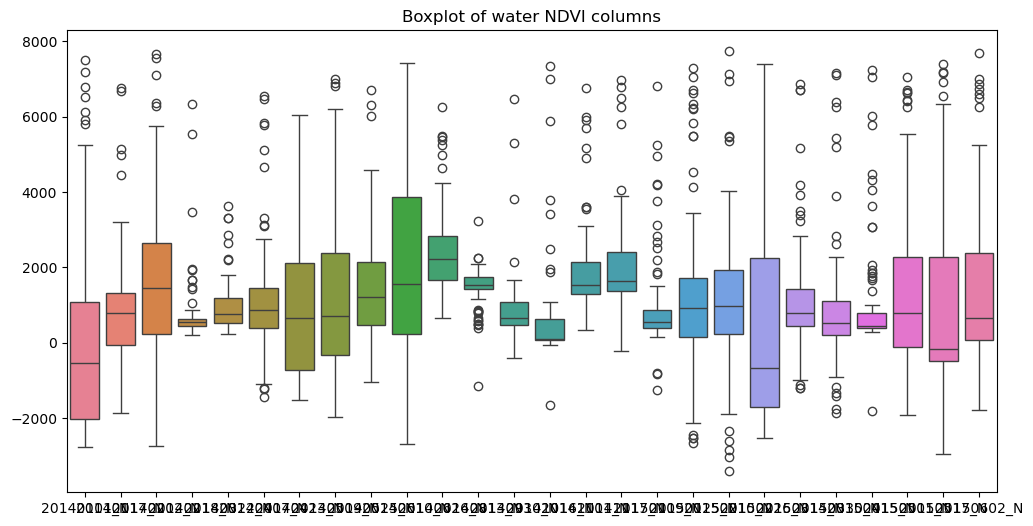

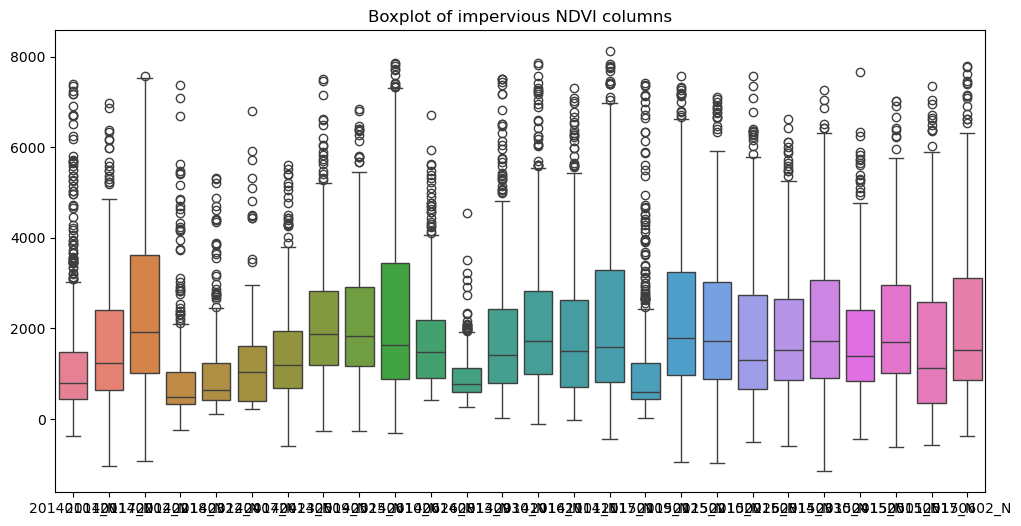

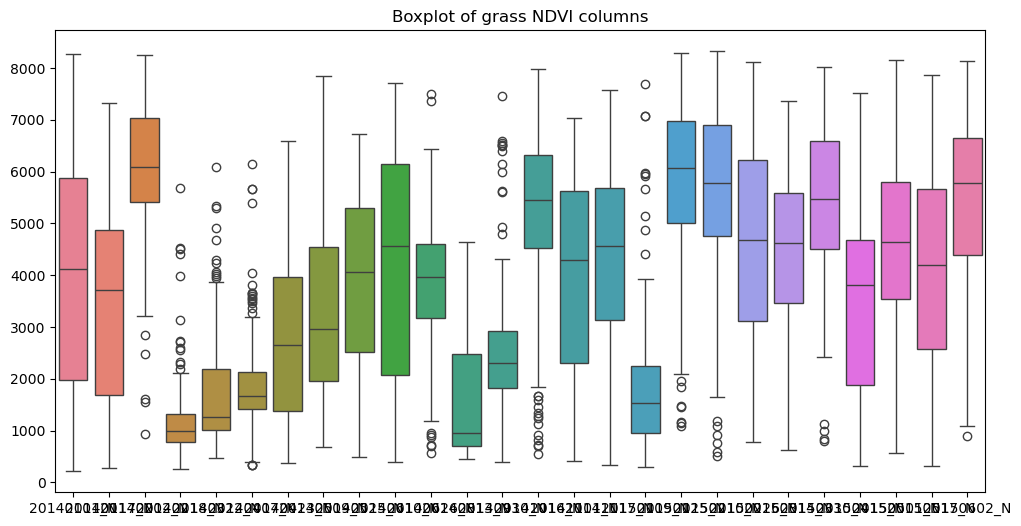

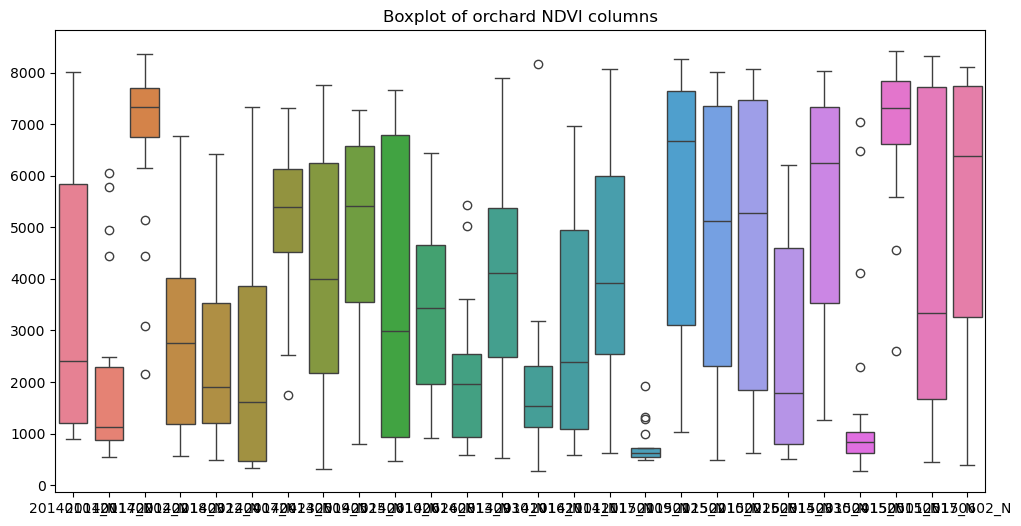

In [4345]:
import matplotlib.pyplot as plt
import seaborn as sns

for cls in train_df['class'].unique().tolist():
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=train_df[train_df['class']==cls][nvdi_columns])  # sample if too large
    plt.title(f"Boxplot of {cls} NDVI columns")
    plt.show()

In [4346]:
for cls in train_df['class'].unique():
    class_mask = train_df['class'] == cls
    for col in nvdi_columns:
        q1 = train_df.loc[class_mask, col].quantile(0.25)
        q3 = train_df.loc[class_mask, col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        train_df.loc[class_mask, col] = train_df.loc[class_mask, col].where(
            train_df.loc[class_mask, col].between(lower, upper), np.nan)
        val_class_mask = val_df['class'] == cls
        val_df.loc[val_class_mask, col] = val_df.loc[val_class_mask, col].where(
            val_df.loc[val_class_mask, col].between(lower, upper), np.nan) 

In [4347]:
from collections import defaultdict

month_to_season={
    12:"Winter",1:"Winter",2:"Winter",
    3:"Spring",4:"Spring",5:"Spring",
    6:"Summer",7:"Summer",8:"Summer",
    9:"Fall",10:"Fall",11:"Fall"
}
season_features=defaultdict(lambda:defaultdict(list))
for year in ["2014","2015"]:
    for col in nvdi_columns:
        if year==col[0:4]:
            month=int(col[4:6])
            season=month_to_season.get(month)
            season_features[year][season].append(col)

In [4348]:
season_features

defaultdict(<function __main__.<lambda>()>,
            {'2014': defaultdict(list,
                         {'Winter': ['20140101_N',
                           '20140117_N',
                           '20140202_N',
                           '20140218_N'],
                          'Spring': ['20140322_N',
                           '20140407_N',
                           '20140423_N',
                           '20140509_N',
                           '20140525_N'],
                          'Summer': ['20140610_N', '20140626_N', '20140813_N'],
                          'Fall': ['20140930_N',
                           '20141016_N',
                           '20141101_N',
                           '20141117_N']}),
             '2015': defaultdict(list,
                         {'Winter': ['20150109_N',
                           '20150125_N',
                           '20150210_N',
                           '20150226_N'],
                          'Spring': ['20150314_N',
      

In [4349]:
# for cls in train_df['class'].unique():
#     for col in nvdi_columns:
#         class_mask = train_df['class'] == cls
#         class_medians = train_df.loc[class_mask, col].mean()
#         train_df.loc[class_mask, col] = train_df.loc[class_mask, col].fillna(class_medians)
#         val_df.loc[val_df['class'] == cls, col] = val_df.loc[val_df['class'] == cls, col].fillna(class_medians)
# from sklearn.impute import KNNImputer
# for cls in train_df['class'].unique():
#     train_mask = train_df['class'] == cls
#     val_mask = val_df['class'] == cls
#          # Subsets for this class
#     train_subset = train_df.loc[train_mask, nvdi_columns]
#     val_subset = val_df.loc[val_mask, nvdi_columns]
#           # Combine for fitting KNN on train class only
#     imputer = KNNImputer(n_neighbors=3)
#           # Fit only on train, then transform both train and val subsets
#     train_imputed = imputer.fit_transform(train_subset)
#     val_imputed = imputer.transform(val_subset)
#           # Replace the original missing values with imputed values
#     train_df.loc[train_mask, nvdi_columns] = train_imputed
#     val_df.loc[val_mask, nvdi_columns] = val_imputed
for cls in train_df['class'].unique().tolist():
    train_df.loc[train_df['class']==cls,nvdi_columns]=train_df.loc[train_df['class']==cls,nvdi_columns].fillna(train_df.loc[train_df['class']==cls,nvdi_columns].median())
    val_df.loc[val_df['class']==cls,nvdi_columns]=val_df.loc[val_df['class']==cls,nvdi_columns].fillna(train_df.loc[train_df['class']==cls,nvdi_columns].median())

In [4350]:
from scipy.stats import skew
for year,seasons in season_features.items():
    for season, cols in seasons.items():
        if len(cols)>1:
            train_df[f'{year}_{season}_mean'] = train_df[cols].mean(axis=1)
            # train_df[f'{year}_{season}_std'] = train_df[cols].std(axis=1)
            # train_df[f'{year}_{season}_min'] = train_df[cols].min(axis=1)
            # train_df[f'{year}_{season}_max'] = train_df[cols].max(axis=1)
            # train_df[f'{year}_{season}_range'] = train_df[f'{year}_{season}_max'] - train_df[f'{year}_{season}_min']
            # train_df[f'{year}_{season}_skew'] = train_df[cols].apply(lambda row: skew(row, bias=False), axis=1)
    
            val_df[f'{year}_{season}_mean'] = val_df[cols].mean(axis=1)
            # val_df[f'{year}_{season}_std'] = val_df[cols].std(axis=1)
            # val_df[f'{year}_{season}_min'] = val_df[cols].min(axis=1)
            # val_df[f'{year}_{season}_max'] = val_df[cols].max(axis=1)
            # val_df[f'{year}_{season}_range'] = val_df[f'{year}_{season}_max'] - val_df[f'{year}_{season}_min']
            # val_df[f'{year}_{season}_skew'] = val_df[cols].apply(lambda row: skew(row, bias=False), axis=1)
    
            test_df[f'{year}_{season}_mean'] = test_df[cols].mean(axis=1)
            # test_df[f'{year}_{season}_std'] = test_df[cols].std(axis=1)
            # test_df[f'{year}_{season}_min'] = test_df[cols].min(axis=1)
            # test_df[f'{year}_{season}_max'] = test_df[cols].max(axis=1)
            # test_df[f'{year}_{season}_range'] = test_df[f'{year}_{season}_max'] - test_df[f'{year}_{season}_min']
            # test_df[f'{year}_{season}_skew'] = test_df[cols].apply(lambda row: skew(row, bias=False), axis=1)
        else:
            train_df[f'{year}_{season}_mean'] = train_df[cols].mean(axis=1)
            val_df[f'{year}_{season}_mean'] = val_df[cols].mean(axis=1)
            test_df[f'{year}_{season}_mean'] = test_df[cols].mean(axis=1)



train_df['Winter_minus_Spring'] = train_df['2014_Spring_mean'] - train_df['2014_Winter_mean']
train_df['Summer_minus_Spring'] = train_df['2014_Summer_mean'] - train_df['2014_Spring_mean']
train_df['Summer_minus_Fall'] = train_df['2014_Fall_mean'] - train_df['2014_Summer_mean']
train_df['Spring_minus_Winter'] = train_df['2015_Spring_mean'] - train_df['2015_Winter_mean']
train_df['Spring_minus_Summer'] = train_df['2015_Summer_mean'] - train_df['2015_Spring_mean']


val_df['Winter_minus_Spring'] = val_df['2014_Spring_mean'] - val_df['2014_Winter_mean']
val_df['Summer_minus_Spring'] = val_df['2014_Summer_mean'] - val_df['2014_Spring_mean']
val_df['Summer_minus_Fall'] = val_df['2014_Fall_mean'] - val_df['2014_Summer_mean']
val_df['Spring_minus_Winter'] = val_df['2015_Spring_mean'] - val_df['2015_Winter_mean']
val_df['Spring_minus_Summer'] = val_df['2015_Summer_mean'] - val_df['2015_Spring_mean']



test_df['Winter_minus_Spring'] = test_df['2014_Spring_mean'] - test_df['2014_Winter_mean']
test_df['Summer_minus_Spring'] = test_df['2014_Summer_mean'] - test_df['2014_Spring_mean']
test_df['Summer_minus_Fall'] = test_df['2014_Fall_mean'] - test_df['2014_Summer_mean']
test_df['Spring_minus_Winter'] = test_df['2015_Spring_mean'] - test_df['2015_Winter_mean']
test_df['Spring_minus_Summer'] = test_df['2015_Summer_mean'] - test_df['2015_Spring_mean']





In [4351]:
for i in range(len(nvdi_columns)-1):
    col1=nvdi_columns[i]
    col2=nvdi_columns[i+1]
    train_df[f'diff_{col1}_{col2}']=train_df[col2]-train_df[col1]
    val_df[f'diff_{col1}_{col2}']=val_df[col2]-val_df[col1]
    test_df[f'diff_{col1}_{col2}']=test_df[col2]-test_df[col1]

In [4352]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [4353]:
total_feature=train_df.columns.tolist()[28:]
total_feature

['2014_Winter_mean',
 '2014_Spring_mean',
 '2014_Summer_mean',
 '2014_Fall_mean',
 '2015_Winter_mean',
 '2015_Spring_mean',
 '2015_Summer_mean',
 'Winter_minus_Spring',
 'Summer_minus_Spring',
 'Summer_minus_Fall',
 'Spring_minus_Winter',
 'Spring_minus_Summer',
 'diff_20140101_N_20140117_N',
 'diff_20140117_N_20140202_N',
 'diff_20140202_N_20140218_N',
 'diff_20140218_N_20140322_N',
 'diff_20140322_N_20140407_N',
 'diff_20140407_N_20140423_N',
 'diff_20140423_N_20140509_N',
 'diff_20140509_N_20140525_N',
 'diff_20140525_N_20140610_N',
 'diff_20140610_N_20140626_N',
 'diff_20140626_N_20140813_N',
 'diff_20140813_N_20140930_N',
 'diff_20140930_N_20141016_N',
 'diff_20141016_N_20141101_N',
 'diff_20141101_N_20141117_N',
 'diff_20141117_N_20150109_N',
 'diff_20150109_N_20150125_N',
 'diff_20150125_N_20150210_N',
 'diff_20150210_N_20150226_N',
 'diff_20150226_N_20150314_N',
 'diff_20150314_N_20150330_N',
 'diff_20150330_N_20150415_N',
 'diff_20150415_N_20150501_N',
 'diff_20150501_N_201505

In [4354]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from imblearn.over_sampling import SMOTE



x_train=train_df[total_feature]
x_val=val_df[total_feature]
y_train=train_df['class']
y_val=val_df['class']
test_df=test_df[total_feature]

scaler=StandardScaler()
X_train_poly=scaler.fit_transform(x_train)
X_val_poly=scaler.transform(x_val)
y_train=le.fit_transform(y_train)
y_val=le.transform(y_val)
test_df=scaler.transform(test_df)


X_train_poly = poly.fit_transform(X_train_poly)
X_val_poly = poly.transform(X_val_poly)
test_df_poly=poly.transform(test_df)

smote = SMOTE(random_state=42,k_neighbors=2)
X_train_poly, y_train = smote.fit_resample(X_train_poly, y_train)

In [4355]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import Pipeline

# # Define multiple logistic models (with different settings)
# log1 = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced', random_state=1)
# log2 = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=2)
# log3 = LogisticRegression(C=10, max_iter=1000, class_weight='balanced', random_state=3)
# log4 = LogisticRegression(C=0.01, max_iter=1000, class_weight='balanced', random_state=4)
# log5 = LogisticRegression(C=100, max_iter=1000, class_weight='balanced', random_state=5)


# # Combine into VotingClassifier with soft voting
# model = VotingClassifier(
#     estimators=[
#         ('lr1', log1),
#         ('lr2', log2),
#         ('lr3', log3),
#         ('lr4',log4),
#         ('lr5',log5)
#     ],
#     voting='soft'  # <- soft voting uses predict_proba
# )

# # Fit and evaluate
# model.fit(X_train_poly, y_train)
# y_pred = model.predict(X_val_poly)

# # Example accuracy
# from sklearn.metrics import accuracy_score
# print("Voting accuracy:", accuracy_score(y_val, y_pred))


In [4356]:
# from sklearn.linear_model import LogisticRegression
model=LogisticRegression(
    C=10,
    class_weight='balanced',
    max_iter=1000,
    penalty='l2',
    solver='lbfgs',
    random_state=42)
model.fit(X_train_poly,y_train)
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression

# # Define the model
# log_reg = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

# # Define hyperparameters to search
# param_grid = {
#     'C': [0.01, 0.1, 1, 10,100],
#     'penalty': ['l2'],  # Only 'l2' works with solver='lbfgs'
#     'solver': ['lbfgs']
# }

# # GridSearchCV
# grid_search = GridSearchCV(
#     estimator=log_reg,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='accuracy',
#     n_jobs=-1,  # Use all CPU cores
#     verbose=1
# )

# # Fit to training data
# grid_search.fit(X_train_poly, y_train)
# grid_search.score(X_val_poly,y_val)
# # Best model and score
# # print("Best parameters:", grid_search.best_params_)
# # print("Best cross-validation accuracy:", grid_search.best_score_)


LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [4358]:
model.score(X_val_poly,y_val)

0.96375

In [4361]:
from sklearn.metrics import classification_report,confusion_matrix
pred_val=model.predict(X_val_poly)
print(classification_report(y_val,pred_val))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       168
           1       0.98      0.99      0.98      1232
           2       0.91      0.82      0.86        39
           3       0.92      0.96      0.94       134
           4       0.67      0.33      0.44         6
           5       1.00      0.86      0.92        21

    accuracy                           0.96      1600
   macro avg       0.89      0.80      0.84      1600
weighted avg       0.96      0.96      0.96      1600



In [4368]:
le.classes_

array(['farm', 'forest', 'grass', 'impervious', 'orchard', 'water'],
      dtype=object)

In [4371]:
print(confusion_matrix(y_val,pred_val))

[[ 147   16    0    4    1    0]
 [  13 1215    2    2    0    0]
 [   2    3   32    2    0    0]
 [   5    0    1  128    0    0]
 [   0    4    0    0    2    0]
 [   0    0    0    3    0   18]]


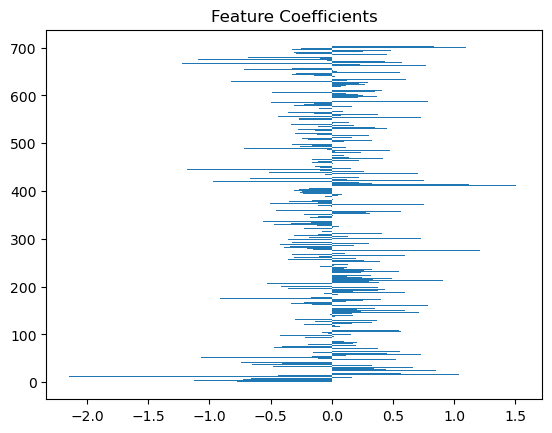

In [4372]:
coeffs = model.coef_[0]
plt.barh(range(len(coeffs)), coeffs)
plt.title("Feature Coefficients")
plt.show()


In [4373]:
# test_df=scaler.transform(test_df_poly)

In [4374]:
test_pred=model.predict(test_df_poly)

In [4377]:
test_pred=le.inverse_transform(test_pred)

In [4379]:
raw_test_id=pd.read_csv('hacktest.csv')['ID']

In [4381]:
submission=pd.DataFrame({
    "ID":raw_test_id,
    "class":test_pred
})
submission.to_csv("submission_new_30_balanced.csv", index=False)